In [1]:
import pandas as pd
!pip install py7zr
import py7zr
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense
from keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import SGD,Adam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 22.3 MB/s eta 0:00:00


Week # 1-2 Data Preprocessong & Preparation

In [3]:
with py7zr.SevenZipFile('/content/train.json.7z', mode='r') as z:
    z.extractall(path='/content/extracted_files')  # Extract to a specific directory

with py7zr.SevenZipFile('/content/test.json.7z', mode='r') as z1:
    z1.extractall(path='/content/extracted_files')  # Extract to the same directory

In [4]:
train = pd.read_json('/content/extracted_files/data/processed/train.json')
test = pd.read_json('/content/extracted_files/data/processed/test.json')
train.head()


,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [5]:
import pandas as pd

# Load the train and test datasets
train = pd.read_json('/content/extracted_files/data/processed/train.json')
test = pd.read_json('/content/extracted_files/data/processed/test.json')

# Check the number of images in the train and test datasets
num_train_images = len(train)
num_test_images = len(test)

print(f"Number of images in the training set: {num_train_images}")
print(f"Number of images in the test set: {num_test_images}")

Number of images in the training set: 1604
Number of images in the test set: 8424


In [6]:
import numpy as np

def scale_images(data_frame):
    image_list = []

    for index, data_row in data_frame.iterrows():
        # Reshape the bands into 75x75 images
        band1 = np.array(data_row['band_1']).reshape(75, 75)
        band2 = np.array(data_row['band_2']).reshape(75, 75)
        combined_band = band1 + band2  # Addition because log(x*y) = log(x) + log(y)

        # Normalize each band by subtracting the mean and dividing by the range
        normalized_band1 = (band1 - band1.mean()) / (band1.max() - band1.min())
        normalized_band2 = (band2 - band2.mean()) / (band2.max() - band2.min())
        normalized_combined_band = (combined_band - combined_band.mean()) / (combined_band.max() - combined_band.min())

        # Stack the three bands into a single image and append to the list
        image_list.append(np.dstack((normalized_band1, normalized_band2, normalized_combined_band)))

    return np.array(image_list)

In [7]:
# Process the images and retrieve the target labels
image_data = scale_images(train)
target_labels = np.array(train['is_iceberg'])

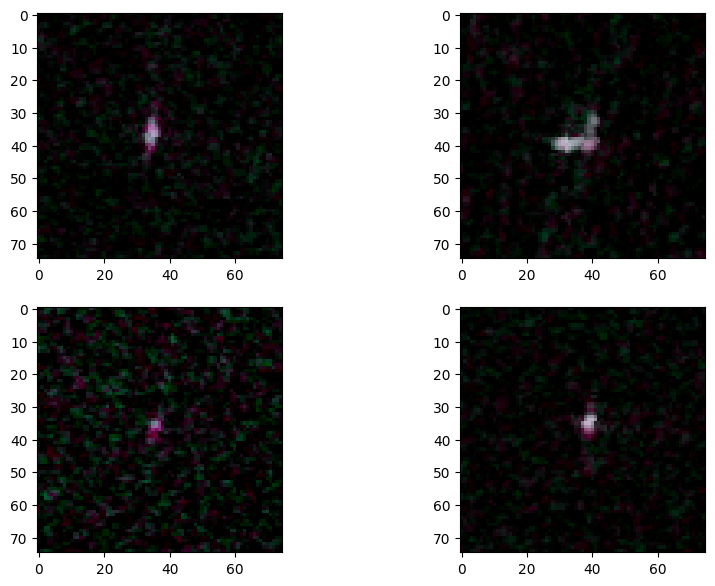

In [8]:
# Set up the figure and define its dimensions
figure = plt.figure(figsize=(10, 7))
num_rows = 2
num_columns = 2

# Loop to create subplots and display images
for index in range(4):
    # Add subplot in the appropriate grid position
    figure.add_subplot(num_rows, num_columns, index + 1)
    plt.imshow(image_data[index])

In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    image_data, target_labels, test_size=0.2, random_state=1
)

Week2-4: Worked on ResNet50 then introduced custom CNN

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Initialize a sequential model
neural_net = Sequential()

# First convolutional block
neural_net.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(75, 75, 3)))
neural_net.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
neural_net.add(Dropout(0.2))

# Second convolutional block
neural_net.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
neural_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
neural_net.add(Dropout(0.2))

# Third convolutional block
neural_net.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
neural_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
neural_net.add(Dropout(0.2))

# Fourth convolutional block
neural_net.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
neural_net.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
neural_net.add(Dropout(0.2))

# Flattening the output for the dense layers
neural_net.add(Flatten())

# First fully connected layer
neural_net.add(Dense(512, activation='relu'))
neural_net.add(Dropout(0.2))

# Second fully connected layer
neural_net.add(Dense(256, activation='relu'))
neural_net.add(Dropout(0.2))

# Output layer with sigmoid activation for binary classification
neural_net.add(Dense(1, activation="sigmoid"))

# Compile the model with Adam optimizer and binary cross-entropy loss
opt = Adam(learning_rate=1e-4)
neural_net.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Display model summary
neural_net.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 5, 5, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 560,193 (2.14 MB)

 Trainable params: 560,193 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Week # 4: Model parameter Fine-tuning

In [11]:
import keras

# Change file extension for the weights file
weights_file = "best_model_weights.keras"

# Callback for saving the model with the highest validation accuracy
save_best_model = keras.callbacks.ModelCheckpoint(
    filepath=weights_file, monitor="val_accuracy", save_best_only=True, mode="max"
)

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr_on_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True
)

# Callback for early stopping if no improvement in validation accuracy
early_stopping_monitor = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, mode="max", verbose=True
)

# List of callbacks to be used during training
callback_functions = [save_best_model, reduce_lr_on_plateau, early_stopping_monitor]

Week # 5: Initial Training and Evaluation


In [12]:
# Train the model with the specified parameters
training_history = neural_net.fit(
    X_train, Y_train,
    batch_size=10,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    callbacks=callback_functions
)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 265ms/step - accuracy: 0.5129 - loss: 0.6923 - val_accuracy: 0.5447 - val_loss: 0.6809 - learning_rate: 1.0000e-04
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 262ms/step - accuracy: 0.5608 - loss: 0.6715 - val_accuracy: 0.6654 - val_loss: 0.6382 - learning_rate: 1.0000e-04
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.6265 - loss: 0.6227 - val_accuracy: 0.6304 - val_loss: 0.6357 - learning_rate: 1.0000e-04
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 265ms/step - accuracy: 0.7017 - loss: 0.5622 - val_accuracy: 0.7665 - val_loss: 0.4791 - learning_rate: 1.0000e-04
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 40s 261ms/step - accuracy: 0.7904 - loss: 0.4648 - val_accuracy: 0.7977 - val_loss: 0.4384 - learning_rate: 1.0000e-04
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 26s 251ms/step - accuracy: 0.8053 - loss: 0.4075 - val_accuracy: 0.8093 - val_loss: 0.4025 - learning_rate: 1.0000e-04
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━

In [13]:
# Convert the training history to a DataFrame
history_df = pd.DataFrame.from_dict(training_history.history)

# Retrieve training parameters
training_params = training_history.params

# Get the keys from the history dictionary
history_metrics = training_history.history.keys()

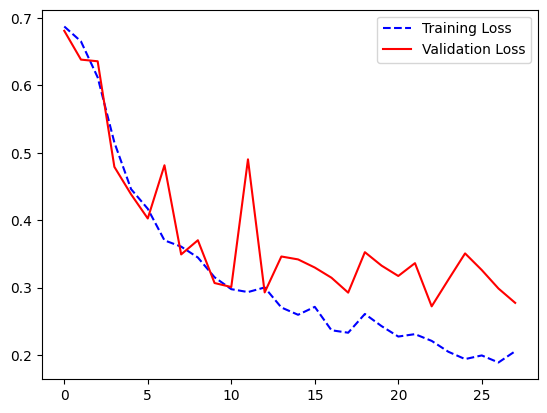

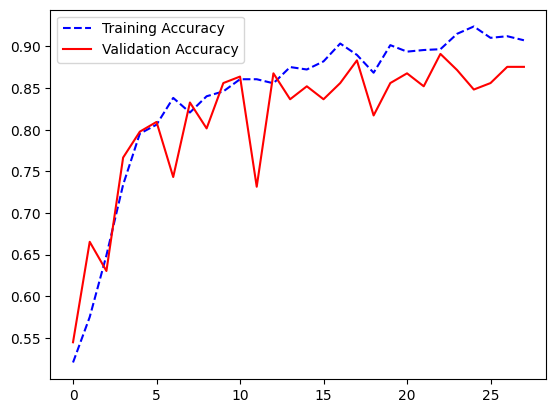

In [14]:
# Plot the training and validation loss
history_df['loss'].plot(style='b--', label='Training Loss')
history_df['val_loss'].plot(style='r-', label='Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
history_df['accuracy'].plot(style='b--', label='Training Accuracy')
history_df['val_accuracy'].plot(style='r-', label='Validation Accuracy')
plt.legend()
plt.show()

In [15]:
# Define the path to the saved model
model_path = "./best_model_weights.keras"

# Load the pre-trained model from the specified file
neural_net = keras.models.load_model(model_path)

In [16]:
# Evaluate the model on the test set
test_score = neural_net.evaluate(X_test, Y_test, verbose=0)

# Display the test loss and accuracy
print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

Test Loss: 0.25884172320365906
Test Accuracy: 0.8940809965133667
